In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (121037, 17)

First few rows:
   VIN (1-10)     County     City State  Postal Code  Model Year    Make  \
0  WA1E2AFY8R   Thurston  Olympia    WA      98512.0        2024    AUDI   
1  WAUUPBFF4J     Yakima   Wapato    WA      98951.0        2018    AUDI   
2  1N4AZ0CP0F       King  Seattle    WA      98125.0        2015  NISSAN   
3  WA1VAAGE5K       King     Kent    WA      98031.0        2019    AUDI   
4  7SAXCAE57N  Snohomish  Bothell    WA      98021.0        2022   TESLA   

     Model                   Electric Vehicle Type  \
0     Q5 E  Plug-in Hybrid Electric Vehicle (PHEV)   
1       A3  Plug-in Hybrid Electric Vehicle (PHEV)   
2     LEAF          Battery Electric Vehicle (BEV)   
3   E-TRON          Battery Electric Vehicle (BEV)   
4  MODEL X          Battery Electric Vehicle (BEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0              Not eligible due to low battery range            23.0   
1              Not eligible d

In [ ]:
# Create a copy for cleaning
df_clean = df.copy()

# 1. Check for duplicates
print("Duplicate rows:", df_clean.duplicated().sum())

# 2. Handle missing values
print("\nMissing values before cleaning:")
print(df_clean.isnull().sum())

# Fill missing numerical values with median
numerical_cols = ['Model Year', 'Electric Range', 'Base MSRP', 'Legislative District']
for col in numerical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Fill missing categorical values with 'Unknown'
categorical_cols = ['County', 'City', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('Unknown')

print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

# 3. Extract useful features from existing columns
# Extract latitude and longitude from Vehicle Location
def extract_lat_lon(location):
    if pd.isna(location) or 'POINT' not in str(location):
        return np.nan, np.nan
    try:
        coords = location.replace('POINT (', '').replace(')', '').split()
        return float(coords[0]), float(coords[1])
    except:
        return np.nan, np.nan

df_clean['Longitude'] = df_clean['Vehicle Location'].apply(lambda x: extract_lat_lon(x)[0])
df_clean['Latitude'] = df_clean['Vehicle Location'].apply(lambda x: extract_lat_lon(x)[1])

# 4. Create age feature from Model Year
df_clean['Vehicle Age'] = 2024 - df_clean['Model Year']

# 5. Simplify CAFV Eligibility
df_clean['CAFV_Simplified'] = df_clean['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].apply(
    lambda x: 'Eligible' if 'Clean Alternative Fuel Vehicle Eligible' in str(x)
    else 'Not Eligible' if 'Not eligible' in str(x)
    else 'Unknown'
)

print("\nCleaned dataset info:")
print(df_clean.info())

Duplicate rows: 0

Missing values before cleaning:
VIN (1-10)                                             0
County                                                 1
City                                                   1
State                                                  0
Postal Code                                            1
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         4
Base MSRP                                              4
Legislative District                                 147
DOL Vehicle ID                                         1
Vehicle Location                                       7
Electric Utility                                       2
2020 Census Tract                    

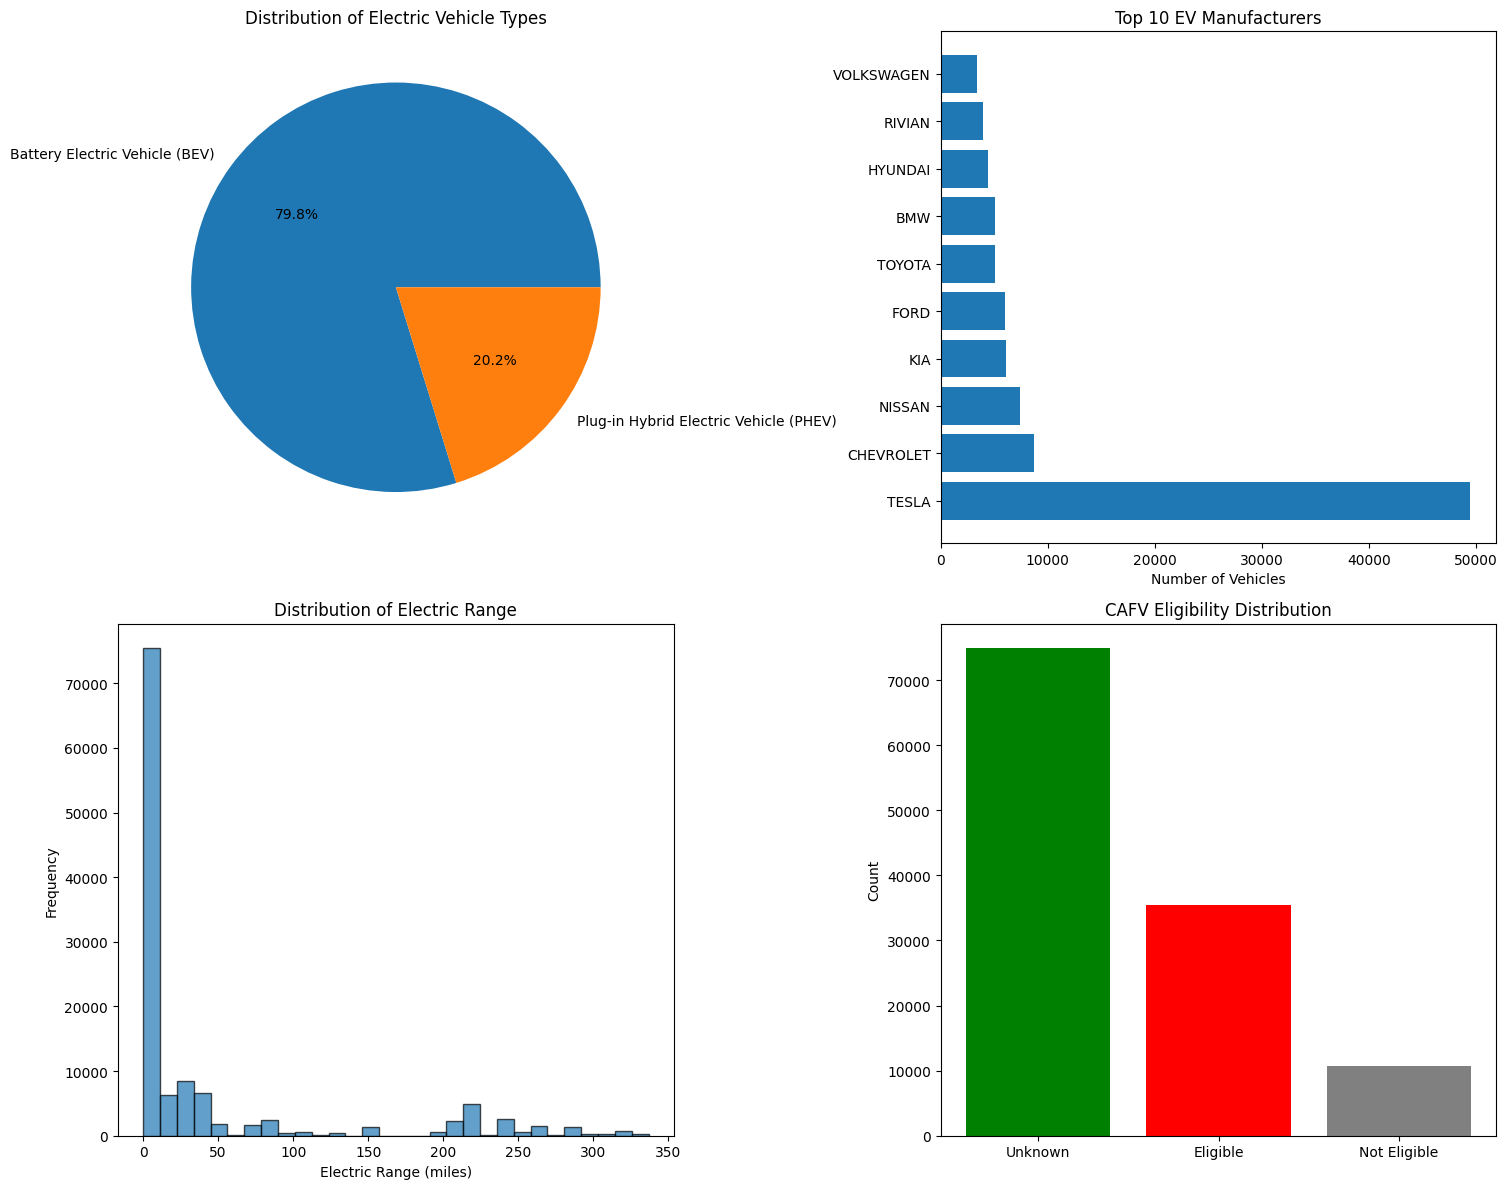

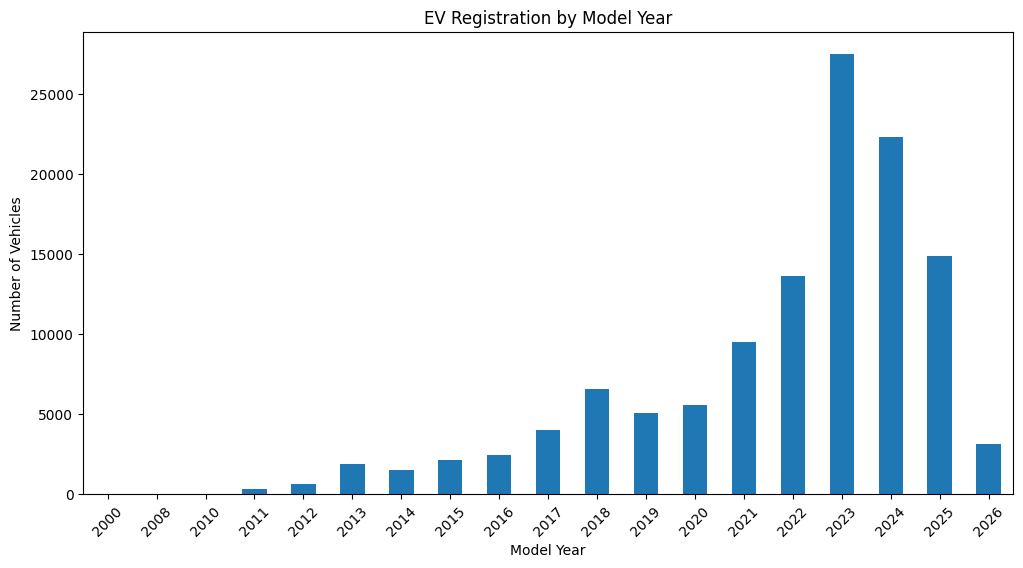

In [ ]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of Electric Vehicle Types
ev_type_counts = df_clean['Electric Vehicle Type'].value_counts()
axes[0,0].pie(ev_type_counts.values, labels=ev_type_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Distribution of Electric Vehicle Types')

# 2. Top 10 EV Makes
top_makes = df_clean['Make'].value_counts().head(10)
axes[0,1].barh(top_makes.index, top_makes.values)
axes[0,1].set_title('Top 10 EV Manufacturers')
axes[0,1].set_xlabel('Number of Vehicles')

# 3. Distribution of Electric Range
axes[1,0].hist(df_clean['Electric Range'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1,0].set_title('Distribution of Electric Range')
axes[1,0].set_xlabel('Electric Range (miles)')
axes[1,0].set_ylabel('Frequency')

# 4. CAFV Eligibility
cafv_counts = df_clean['CAFV_Simplified'].value_counts()
axes[1,1].bar(cafv_counts.index, cafv_counts.values, color=['green', 'red', 'gray'])
axes[1,1].set_title('CAFV Eligibility Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 5. Model Year distribution
plt.figure(figsize=(12, 6))
df_clean['Model Year'].value_counts().sort_index().plot(kind='bar')
plt.title('EV Registration by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Select features for prediction
features = ['Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Base MSRP', 'Vehicle Age']
target = 'Electric Range'

# Create feature set
X = df_clean[features].copy()
y = df_clean[target]

# Encode categorical variables
label_encoders = {}
for col in ['Make', 'Model', 'Electric Vehicle Type']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (96829, 6)
Testing set shape: (24208, 6)


In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

    print(f"\n{name} Results:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

# Feature importance for Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Linear Regression Results:
MAE: 47.05
MSE: 4376.63
R2 Score: 0.32

Random Forest Results:
MAE: 0.64
MSE: 29.68
R2 Score: 1.00

Feature Importance:
                 feature  importance
0             Model Year    0.357404
5            Vehicle Age    0.327331
3  Electric Vehicle Type    0.234098
1                   Make    0.053359
2                  Model    0.027320
4              Base MSRP    0.000487
